---
# 종합실습 1
---
## 인도의 중고차를 팔아보자!
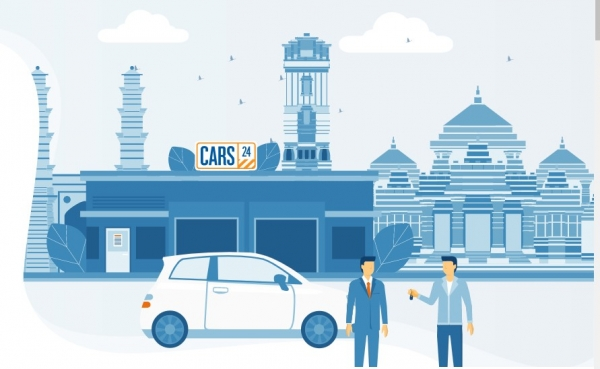
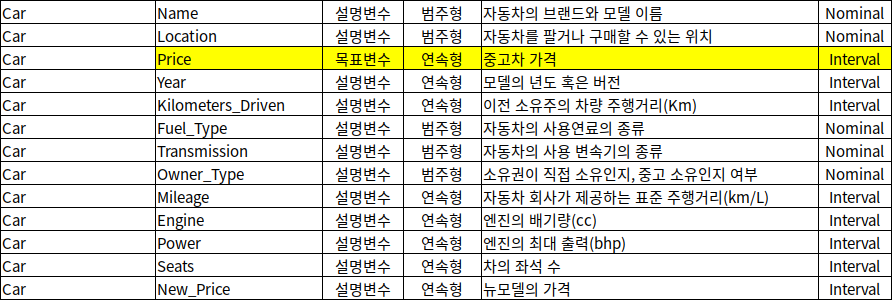
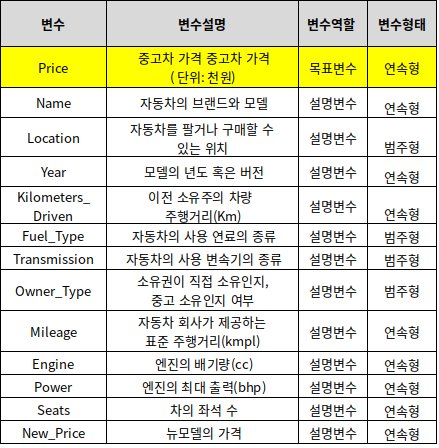

## 1. 데이터 전처리
    (1) 'Price' 결측치(1000개) 제거 (추후 활용)
    (2) 'Engine','Power','Seat' 공통 결측치 46개 제거
    (3) 'Seat' 결측치 7개 보완
    (4) 'Mileage','Engine','Power' 칼럼 값 단위 split()
    (5) 이상치 확인 -> (너무 over면 삭제, 모르겠다? -> 질문)

In [9]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

matplotlib.rc("font", family = 'NanumGothic')
matplotlib.rc("axes", unicode_minus = False)

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_csv("/home/piai/test/BD02/Car.csv",encoding='euc-kr')
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


In [12]:
# 변수 목록
df.columns

Index(['Name', 'Location', 'Price', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price'],
      dtype='object')

In [13]:
# 변수 간 상관관계 확인
df.corr()

,Price,Year,Kilometers_Driven,Seats
Price,1.000000,0.303140,-0.014603,0.052650
Year,0.303140,1.000000,-0.187859,0.008216
Kilometers_Driven,-0.014603,-0.187859,1.000000,0.090221
Seats,0.052650,0.008216,0.090221,1.000000


In [14]:
df['Location'].value_counts() # 지역 11개

Mumbai        949
Hyderabad     876
Coimbatore    772
Kochi         772
Pune          765
Delhi         660
Kolkata       654
Chennai       591
Jaipur        499
Bangalore     440
Ahmedabad     275
Name: Location, dtype: int64

In [15]:
df['Fuel_Type'].value_counts() # 유종 5개

Diesel      3852
Petrol      3325
CNG           62
LPG           12
Electric       2
Name: Fuel_Type, dtype: int64

In [16]:
df['Transmission'].value_counts() # 자동,수동

Manual       5204
Automatic    2049
Name: Transmission, dtype: int64

In [17]:
df['Owner_Type'].value_counts() # 처음,두번째,세번째,네번 그 이상

First             5952
Second            1152
Third              137
Fourth & Above      12
Name: Owner_Type, dtype: int64

In [18]:
df['Seats'].value_counts() # 0~10 인승까지 0 변환 필요 1개, nan 변환 필요 53개

5.0     6047
7.0      796
8.0      170
4.0      119
6.0       38
2.0       18
10.0       8
9.0        3
0.0        1
Name: Seats, dtype: int64

* 결측치 보강 방안 : Name 활용 시트수 데이터 보강

### 중복행 확인

In [19]:
# 중복된 모든 행 확인하기
duplicates = df[df.duplicated()]

print("중복 데이터:")
print(duplicates)

중복 데이터:
                     Name Location  Price  Year  Kilometers_Driven Fuel_Type  \
6582  Honda City 1.5 E MT   Mumbai    NaN  2010              52000    Petrol   

     Transmission Owner_Type    Mileage   Engine    Power  Seats New_Price  
6582       Manual      First  17.0 kmpl  1497 CC  118 bhp    5.0       NaN  


In [20]:
# 중복 데이터 제거
df_unique = df.drop_duplicates()

### 1-1. 'New_Price' 칼럼 삭제
    데이터의 50% 이상이 결측치이므로 분석에 도움이 되지 않는다 판단하여 삭제

In [21]:
del df_unique['New_Price']

### 1-2. 'Price' 결측치(1000개) 제거

In [22]:
df_new = df_unique[~df_unique['Price'].isna()]
df_new.isnull().sum() #Price 결측치 제거 확인

Name                  0
Location              0
Price                 0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
dtype: int64

### 1-3. 'Engine','Power','Seat' 공통 결측치 46개 제거

In [23]:
df_new = df_new[~((df_new['Engine'].isna())&(df_new['Power'].isna())&(df_new['Seats'].isna()))]

In [24]:
df_new.isnull().sum() #'Engine','Power','Seat' 공통 결측치 46개 제거 확인

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              2
Engine               0
Power                0
Seats                6
dtype: int64

### 1-4. 결측치 보완을 위해 'Name' 칼럼을 'Brand','Model' 칼럼으로 분리

In [25]:
# 'Name' 컬럼을 'Brand'와 'Model'로 분리
df_new['Brand'] = df_new['Name'].apply(lambda x: x.split(' ', 1)[0])  # 첫 번째 공백까지가 브랜드명
df_new['Model'] = df_new['Name'].apply(lambda x: x.split(' ', 1)[1] if len(x.split(' ', 1)) > 1 else '')  # 첫 번째 공백 이후가 모델명

In [26]:
# 자동차 회사명,품명 칼럼이 있으니 기존 'Name' 칼럼 삭제
del df_new['Name']

In [27]:
# 자동차 회사명중 한단어 이상의 이름일 경우 'Model'로 회사명의 일부가 넘어갈 수 있음.
df_new['Brand'].value_counts()

Maruti           1243
Hyundai          1121
Honda             616
Toyota            422
Mercedes-Benz     325
Volkswagen        321
Ford              304
Mahindra          282
BMW               268
Audi              241
Tata              195
Skoda             182
Renault           151
Chevrolet         121
Nissan             95
Land               57
Jaguar             43
Mitsubishi         34
Mini               29
Fiat               28
Volvo              21
Jeep               19
Porsche            18
Datsun             17
ISUZU               3
Force               3
Bentley             2
Smart               1
Ambassador          1
Lamborghini         1
Name: Brand, dtype: int64

* Land ~ 경우 Land Rover 라는 회사명이 공백에 의해 잘렸음
    -> 따로 조치

In [28]:
# 'Brand'가 'Land'이고, 'Model'의 시작 부분이 'Rover'인 행을 수정
def correct_brand_and_model(row):
    if row['Brand'] == 'Land' and row['Model'].startswith('Rover'):
        parts = row['Model'].split(' ', 1)  # 'Rover'와 나머지 부분을 분리
        row['Brand'] += ' ' + parts[0]  # 'Brand'에 'Rover'를 추가
        row['Model'] = parts[1] if len(parts) > 1 else ''  # 'Model'에서 'Rover'를 제거
    return row

# 각 행에 함수 적용
df_new = df_new.apply(correct_brand_and_model, axis=1)

### 1-5. 'Mileage','Engine','Power' 칼럼 값 단위 split()

In [29]:
# 'Mileage', 'Engine', 'Power' 칼럼의 단위 제거 및 숫자형으로 변환
def convert_to_numeric(column):
    return pd.to_numeric(df[column].str.extract('(\d+\.?\d*)')[0], errors='coerce')

df_new['Mileage'] = convert_to_numeric('Mileage')
df_new['Engine'] = convert_to_numeric('Engine')
df_new['Power'] = convert_to_numeric('Power')

In [30]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6164 entries, 0 to 7236
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6164 non-null   object 
 1   Price              6164 non-null   float64
 2   Year               6164 non-null   int64  
 3   Kilometers_Driven  6164 non-null   int64  
 4   Fuel_Type          6164 non-null   object 
 5   Transmission       6164 non-null   object 
 6   Owner_Type         6164 non-null   object 
 7   Mileage            6162 non-null   float64
 8   Engine             6164 non-null   float64
 9   Power              6057 non-null   float64
 10  Seats              6158 non-null   float64
 11  Brand              6164 non-null   object 
 12  Model              6164 non-null   object 
dtypes: float64(5), int64(2), object(6)
memory usage: 674.2+ KB


### 1-6. 'Seats' 결측치 6개 보완 필요

* 'Ford', 'Honda', 'Maruti' 세 종류의 회사에 대해 Seats 결측치 보완 필요
* 'Brand'별로,'Engine'CC량에 따라 적절한 Seats값으로 결측치 보완

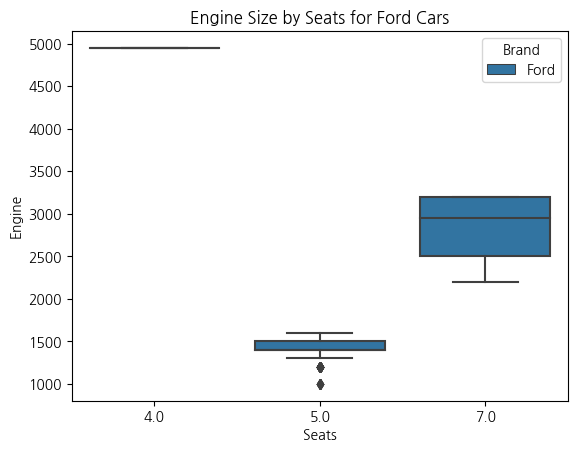

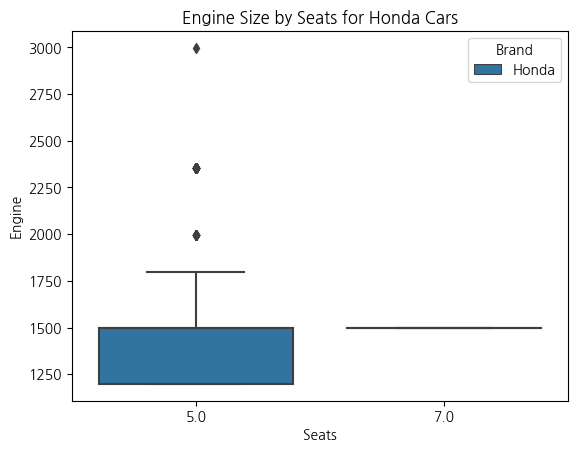

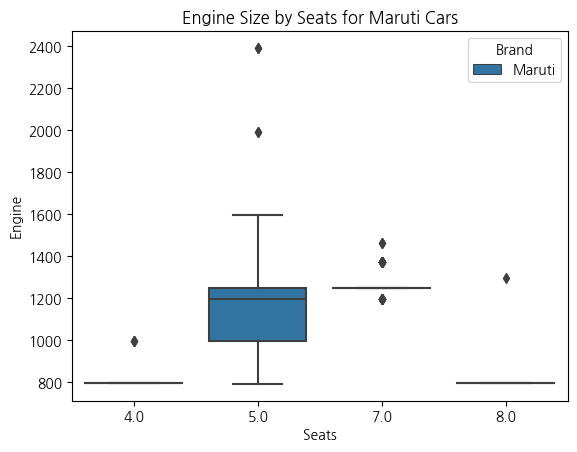

In [31]:
for brand in ['Ford', 'Honda', 'Maruti']:
    # 'Brand'가 'Ford', 'Honda', 'Maruti' 인 데이터 필터링
    df_filtered = df_new[df_new['Brand']==brand]
    # 'Seats' 값별로 'Engine'의 박스플롯 그리기, 'Brand' 별로 구분
    sns.boxplot(x='Seats', y='Engine', hue='Brand', data=df_filtered)
    # 그래프 제목 설정
    plt.title('Engine Size by Seats for {} Cars'.format(brand))
    # 범례 표시
    plt.legend(title='Brand')
    # 그래프 표시
    plt.show()

In [32]:
# 결측치 보완 함수 정의
def impute_seats(row):
    if pd.isna(row['Seats']):
        if row['Brand'] == 'Ford':
            if 1000 <= row['Engine'] <= 2000:
                return 5
            elif 2500 <= row['Engine'] <= 3500:
                return 7
        elif row['Brand'] == 'Honda' and row['Engine'] <= 1500:
            return 5
        elif row['Brand'] == 'Maruti':
            return 5
    return row['Seats']

# 결측치 보완
df_new['Seats'] = df_new.apply(impute_seats, axis=1)

In [33]:
print(df_new.isnull().sum())

Location               0
Price                  0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                 0
Power                107
Seats                  0
Brand                  0
Model                  0
dtype: int64


In [34]:
# 'Brand' 값이 'Smart'가 아닌 행들만 선택하여 데이터프레임을 업데이트
# 해당 브랜드 차종은 'Smart' 하나 밖에 없어서 해당 행을 삭제함.
df_new = df_new[df_new['Brand'] != 'Smart']

### 1-7. split() 후 Power 칼럼의 결측치 발생 -> 보완 필요

In [35]:
# 'Power' 결측치 인덱스
power_null_brand = df_new[df_new['Power'].isna()]['Brand'].unique().tolist()

for brand in power_null_brand:
    # 현재 브랜드에 해당하고 'Power' 열이 결측인 행들을 찾아서 인덱스를 저장
    missing_power_indices = df_new[(df_new['Brand'] == brand) & (df_new['Power'].isna())].index
    # 'Engine' 값으로 정렬된 데이터프레임 생성
    sorted_df = df_new[df_new['Brand'] == brand].sort_values(by='Engine')
    # 결측치 인덱스를 순회하며 각 결측치를 처리
    for idx in missing_power_indices:
        # 현재 결측치 인덱스에 대한 'Engine' 값의 위치 찾기
        current_position = sorted_df.index.get_loc(idx)
        # 현재 위치에서 가장 가까운 이전 및 이후의 유효한 'Power' 값들을 찾음
        valid_indices_before = sorted_df.iloc[:current_position][sorted_df['Power'].notna()].tail(2).index
        valid_indices_after = sorted_df.iloc[current_position + 1:][sorted_df['Power'].notna()].head(2).index
        # 이전 및 이후 유효한 값들의 인덱스를 합침
        indices_to_consider = valid_indices_before.union(valid_indices_after)
        # 선택된 인덱스에 해당하는 'Power' 값의 평균 계산
        mean_power = sorted_df.loc[indices_to_consider, 'Power'].mean(skipna=True)
        # 계산된 평균으로 결측치 대체
        df_new.at[idx, 'Power'] = mean_power

In [36]:
df_new.isnull().sum()

Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              2
Engine               0
Power                0
Seats                0
Brand                0
Model                0
dtype: int64

In [37]:
# 'Mileage' 값이 'NaN' 인 행은 2개 행인데 해당 제품은 같은 회사의 같은 차종이 없어 삭제함.
df_new = df_new.dropna(subset=['Mileage'])

In [38]:
df_new.isnull().sum()

Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Brand                0
Model                0
dtype: int64

### 1-8. 이상치 최종 제거

In [39]:
df_new.describe()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
count,6161.000000,6161.000000,6.161000e+03,6161.000000,6161.000000,6161.000000,6161.000000
mean,14939.849498,2013.459666,5.809770e+04,18.225809,1620.359357,112.895776,5.279175
std,17698.484880,3.251129,9.034959e+04,4.517622,601.220913,54.178508,0.807415
min,7.080000,1998.000000,1.710000e+02,0.000000,624.000000,34.200000,0.000000
25%,5365.360000,2012.000000,3.300000e+04,15.260000,1198.000000,74.900000,5.000000
50%,8814.520000,2014.000000,5.238300e+04,18.200000,1493.000000,93.700000,5.000000
75%,15850.810000,2016.000000,7.220200e+04,21.100000,1984.000000,138.100000,5.000000
max,245273.600000,2019.000000,6.500000e+06,33.540000,5998.000000,616.000000,10.000000


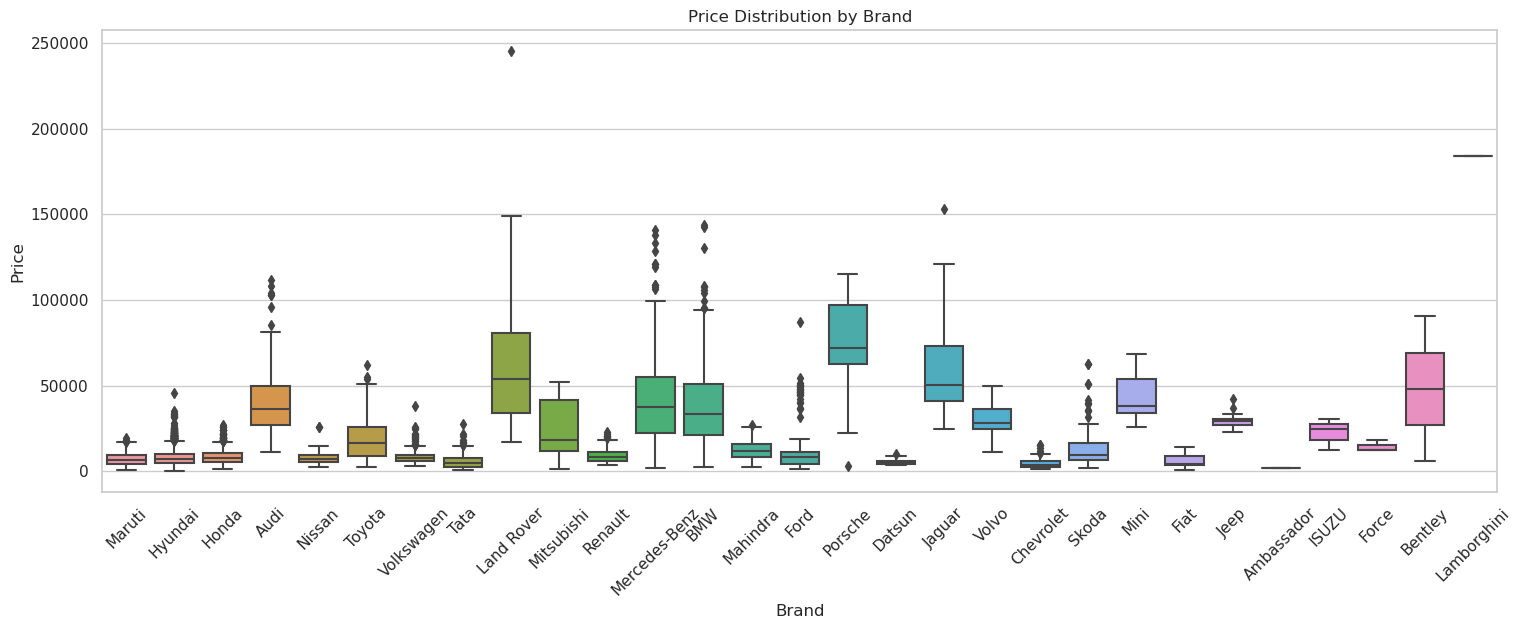

In [40]:
# Seaborn 스타일 설정으로 그래프를 더 보기 좋게 만듦
sns.set(style="whitegrid")

# 'Brand' 별 'Price' 박스플롯 생성
plt.figure(figsize=(18, 6)) # 그래프의 크기 설정
sns.boxplot(x='Brand', y='Price', data=df_new)

plt.title('Price Distribution by Brand') # 그래프 제목 설정
plt.xticks(rotation=45) # x축 레이블 회전으로 긴 이름 처리
plt.show()

#### 'Price' 기준 100,000원 이하 삭제

In [41]:
# 'Year' 에서 이상치 분류 
df_new = df_new[df_new['Year']>1000]

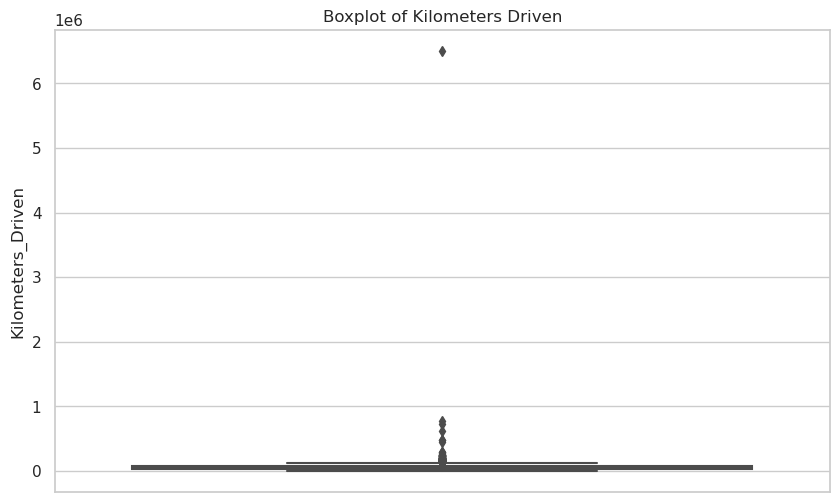

In [42]:
# Seaborn 스타일 설정으로 그래프를 더 보기 좋게 만듦
sns.set(style="whitegrid")

# 'Kilometers_Driven' 칼럼에 대한 박스플롯 생성
plt.figure(figsize=(10, 6)) # 그래프의 크기 설정
sns.boxplot(y=df_new['Kilometers_Driven'])

plt.title('Boxplot of Kilometers Driven') # 그래프 제목 설정
plt.show()

#### 'Kilometers_Driven' 기준 100만 km 이상 삭제

In [43]:
# 사분위수 계산
# 'Kilometers_Driven' 에서 이상치 분류 
df_new = df_new[df_new['Kilometers_Driven']<1000000]

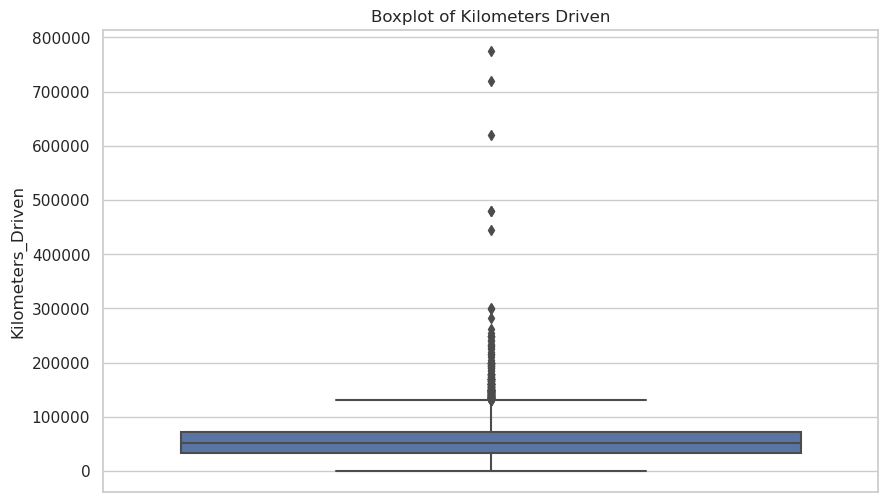

In [44]:
# Seaborn 스타일 설정으로 그래프를 더 보기 좋게 만듦
sns.set(style="whitegrid")

# 'Kilometers_Driven' 칼럼에 대한 박스플롯 생성
plt.figure(figsize=(10, 6)) # 그래프의 크기 설정
sns.boxplot(y=df_new['Kilometers_Driven'])

plt.title('Boxplot of Kilometers Driven') # 그래프 제목 설정
plt.show()

#### 'Mileage' 기준 0 mile 값 변경 필요

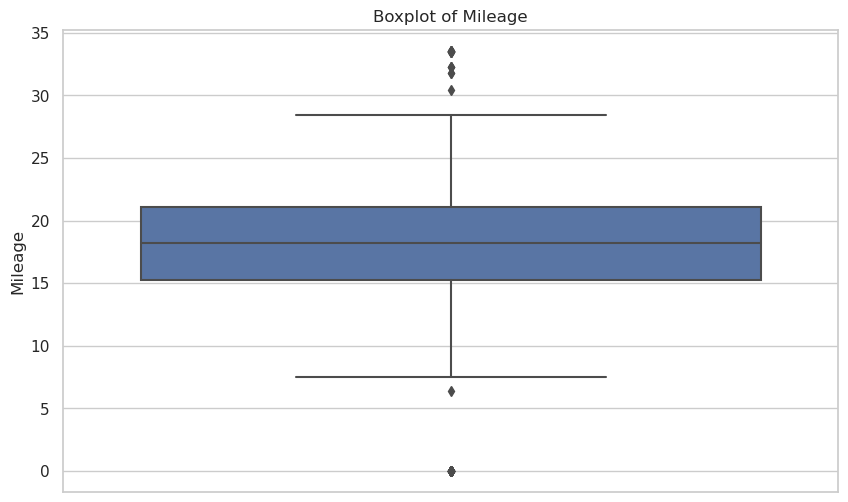

In [45]:
# Seaborn 스타일 설정으로 그래프를 더 보기 좋게 만듦
sns.set(style="whitegrid")

# 'Kilometers_Driven' 칼럼에 대한 박스플롯 생성
plt.figure(figsize=(10, 6)) # 그래프의 크기 설정
sns.boxplot(y=df_new['Mileage'])

plt.title('Boxplot of Mileage') # 그래프 제목 설정
plt.show()

In [46]:
df_new.corr()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
Price,1.000000,0.303504,-0.167274,-0.306848,0.640171,0.755688,0.052805
Year,0.303504,1.000000,-0.454581,0.314217,-0.056128,0.025432,0.010289
Kilometers_Driven,-0.167274,-0.454581,1.000000,-0.145983,0.156057,-0.002540,0.212082
Mileage,-0.306848,0.314217,-0.145983,1.000000,-0.601127,-0.504282,-0.314316
Engine,0.640171,-0.056128,0.156057,-0.601127,1.000000,0.865896,0.393176
Power,0.755688,0.025432,-0.002540,-0.504282,0.865896,1.000000,0.091948
Seats,0.052805,0.010289,0.212082,-0.314316,0.393176,0.091948,1.000000


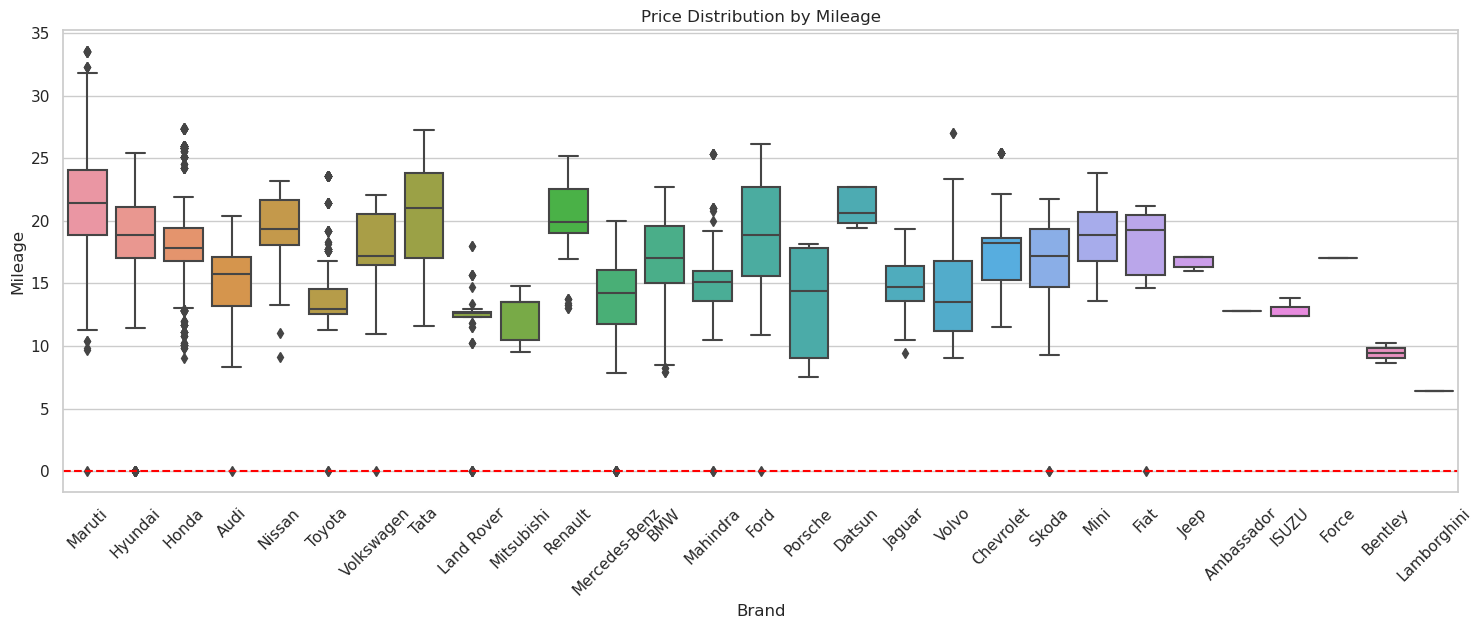

In [47]:
# Seaborn 스타일 설정으로 그래프를 더 보기 좋게 만듦
sns.set(style="whitegrid")

# 'Brand' 별 'Price' 박스플롯 생성
plt.figure(figsize=(18, 6)) # 그래프의 크기 설정
sns.boxplot(x='Brand', y='Mileage', data=df_new)

plt.title('Price Distribution by Mileage') # 그래프 제목 설정
plt.xticks(rotation=45) # x축 레이블 회전으로 긴 이름 처리
plt.axhline(y=0,linestyle='--',color='red')
plt.show()

In [48]:
# 'Mileage' 결측치 인덱스
power_null_brand = df_new[df_new['Mileage']==0]['Brand'].unique().tolist()

for brand in power_null_brand:
    # 현재 브랜드에 해당하고 'Power' 열이 결측인 행들을 찾아서 인덱스를 저장
    missing_power_indices = df_new[(df_new['Brand'] == brand) & (df_new['Mileage']==0)].index
    # 'Engine' 값으로 정렬된 데이터프레임 생성
    sorted_df = df_new[df_new['Brand'] == brand].sort_values(by='Engine')
    # 결측치 인덱스를 순회하며 각 결측치를 처리
    for idx in missing_power_indices:
        # 현재 결측치 인덱스에 대한 'Engine' 값의 위치 찾기
        current_position = sorted_df.index.get_loc(idx)
        # 현재 위치에서 가장 가까운 이전 및 이후의 유효한 'Power' 값들을 찾음
        valid_indices_before = sorted_df.iloc[:current_position][sorted_df['Mileage'].notna()].tail(2).index
        valid_indices_after = sorted_df.iloc[current_position + 1:][sorted_df['Mileage'].notna()].head(2).index
        # 이전 및 이후 유효한 값들의 인덱스를 합침
        indices_to_consider = valid_indices_before.union(valid_indices_after)
        # 선택된 인덱스에 해당하는 'Power' 값의 평균 계산
        mean_mile = sorted_df.loc[indices_to_consider, 'Mileage'].mean(skipna=True)
        # 계산된 평균으로 결측치 대체
        df_new.at[idx, 'Mileage'] = mean_mile

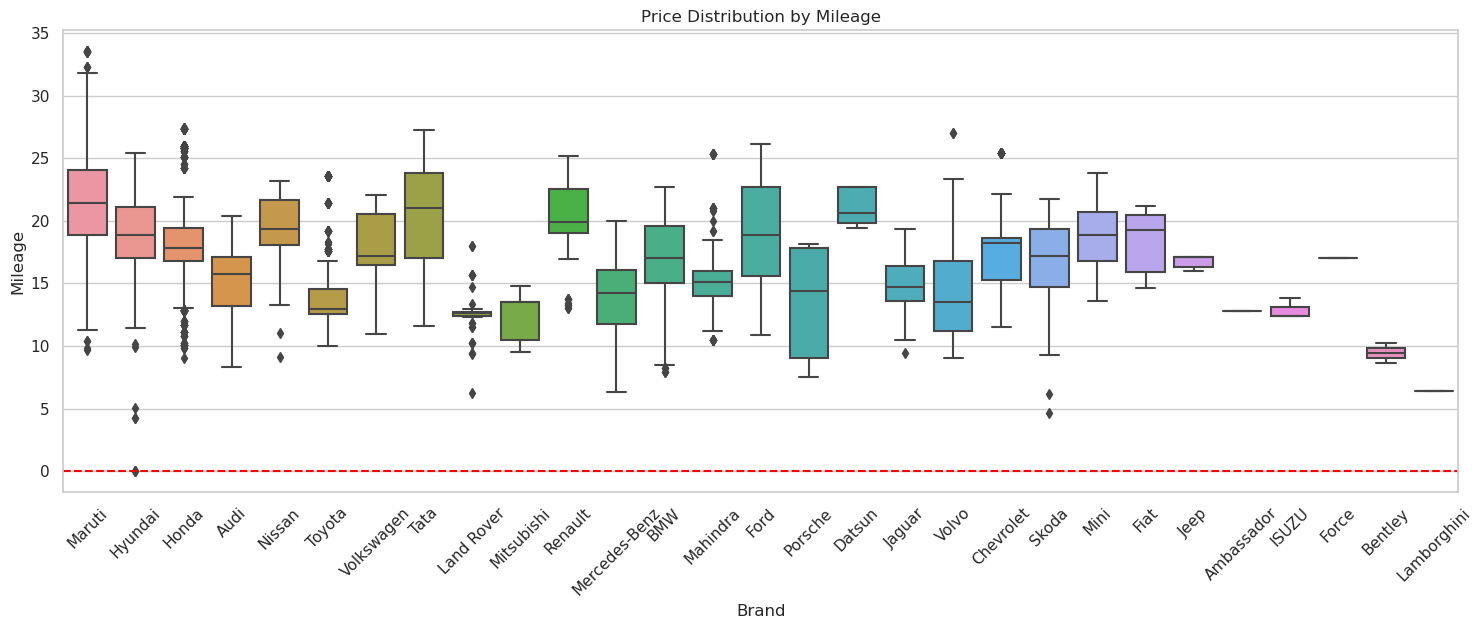

In [49]:
# Seaborn 스타일 설정으로 그래프를 더 보기 좋게 만듦
sns.set(style="whitegrid")

# 'Brand' 별 'Price' 박스플롯 생성
plt.figure(figsize=(18, 6)) # 그래프의 크기 설정
sns.boxplot(x='Brand', y='Mileage', data=df_new)

plt.title('Price Distribution by Mileage') # 그래프 제목 설정
plt.xticks(rotation=45) # x축 레이블 회전으로 긴 이름 처리
plt.axhline(y=0,linestyle='--',color='red')
plt.show()

# 이상치 제거 후 변수 분포

#### 'Brand' 별 'Engine' 값 기준으로 'Milege' 이상치 보완       
#### 보완이 안된 이상치는 'Brand' 별 'Power' 기준으로 'Milege' 이상치 보완

In [50]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6160 entries, 0 to 7236
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6160 non-null   object 
 1   Price              6160 non-null   float64
 2   Year               6160 non-null   int64  
 3   Kilometers_Driven  6160 non-null   int64  
 4   Fuel_Type          6160 non-null   object 
 5   Transmission       6160 non-null   object 
 6   Owner_Type         6160 non-null   object 
 7   Mileage            6160 non-null   float64
 8   Engine             6160 non-null   float64
 9   Power              6160 non-null   float64
 10  Seats              6160 non-null   float64
 11  Brand              6160 non-null   object 
 12  Model              6160 non-null   object 
dtypes: float64(5), int64(2), object(6)
memory usage: 802.8+ KB


In [51]:
df_new['Fuel_Type'].unique()

array(['CNG', 'Diesel', 'Petrol', 'LPG'], dtype=object)

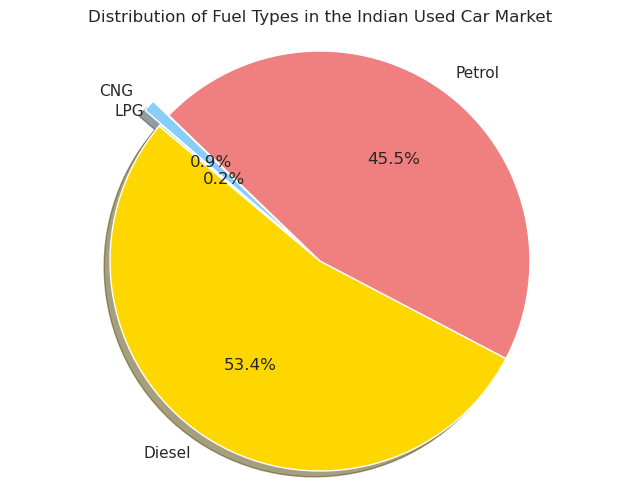

In [52]:
# 데이터 프레임에서 'Fuel_Type' 열의 고유값과 각 유형의 빈도수를 얻습니다.
fuel_type_counts = df_new['Fuel_Type'].value_counts()

# pie 차트를 그릴 때 사용할 색상을 정의합니다.
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen']
explode = [0, 0, 0.1, 0]
# pie 차트를 그립니다.
plt.figure(figsize=(8, 6))
plt.pie(fuel_type_counts, labels=fuel_type_counts.index, colors=colors, autopct='%1.1f%%',shadow=True,startangle=140,explode=explode)
plt.axis('equal')  # 원을 원형으로 표시합니다.
plt.title('Distribution of Fuel Types in the Indian Used Car Market')
plt.show()

## 2. 가설 검정

### 가설1. Year 별로 Price 가격에 영향이 있다?

- 귀무 가설 (H0): 모든 그룹의 평균이 같다. (즉, 'Year'에 따른 'Price'의 평균에는 차이가 없다.)
- 대립 가설 (H1): 적어도 하나의 그룹의 평균이 다른 그룹들과 다르다. (즉, 'Year'에 따라 'Price'의 평균에 차이가 있다.)



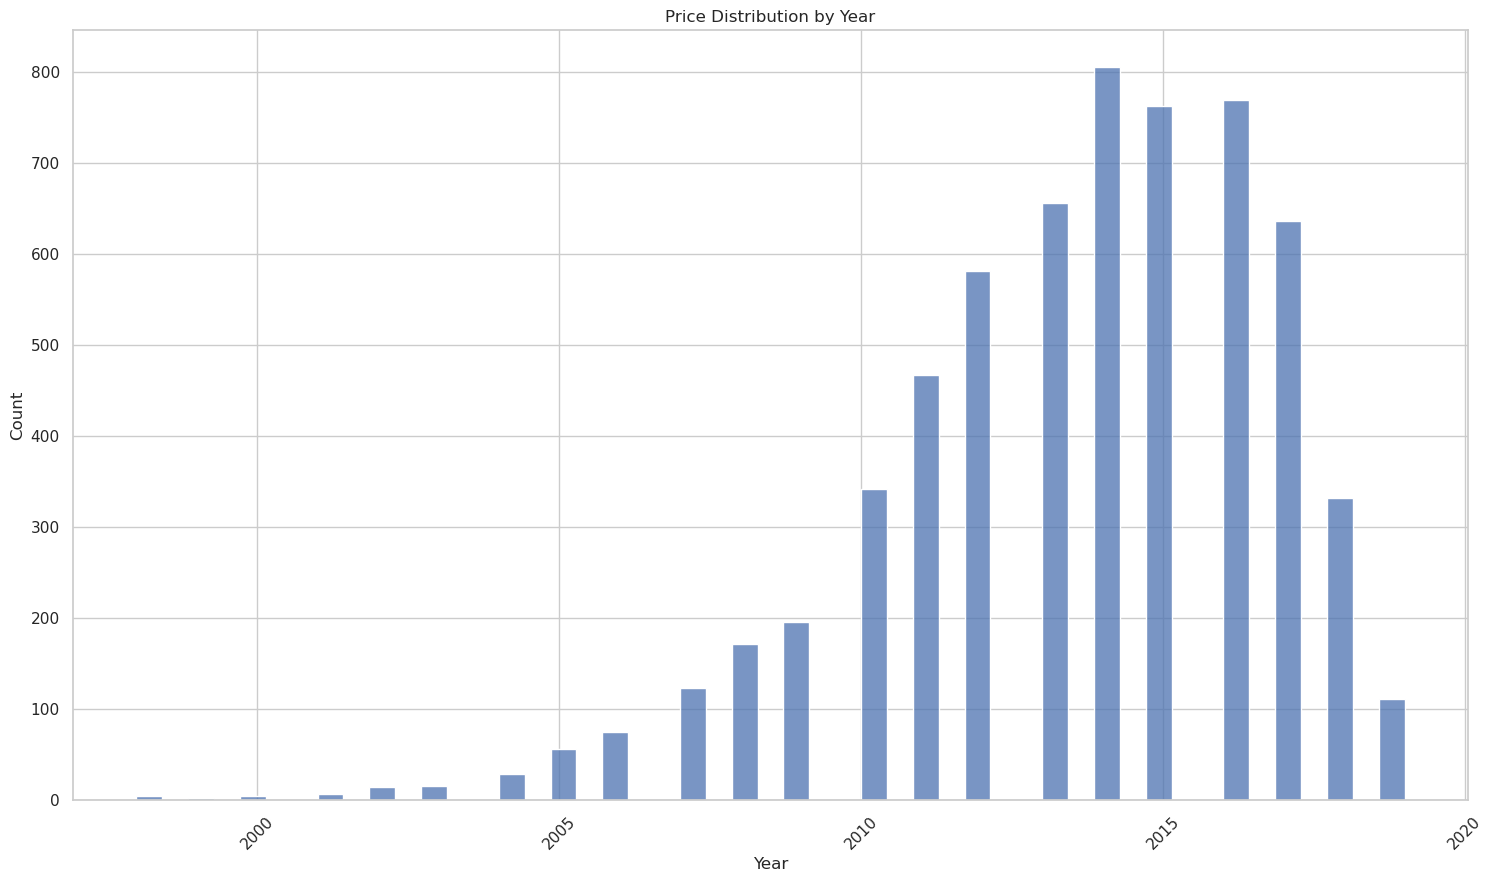

In [53]:
# Seaborn 스타일 설정으로 그래프를 더 보기 좋게 만듦
sns.set(style="whitegrid")

# 'Brand' 별 'Price' 박스플롯 생성
plt.figure(figsize=(18, 10)) # 그래프의 크기 설정
sns.histplot(x='Year', data=df_new)

plt.title('Price Distribution by Year') # 그래프 제목 설정
plt.xticks(rotation=45) # x축 레이블 회전으로 긴 이름 처리
plt.show()

In [54]:
# 정규성 검사
import scipy.stats as stats

# 샘플 크기가 큰 경우, 무작위로 샘플링
sampled_data = df_new.sample(n=5000, random_state=1)

# 다시 정규성 검사 시도
for year in sampled_data['Year'].unique():
    year_data = sampled_data[sampled_data['Year'] == year]['Price']
    if len(year_data) < 100:
        continue
    stat, p = stats.shapiro(year_data.dropna())  # 결측치 제외
    if np.isnan(stat):
        print(f'Year {year}: 데이터 확인 필요')
    else:
        print(f'Year {year}: Statistics={stat}, p={p}')

Year 2018: Statistics=0.7159097194671631, p=1.0212280561906615e-20
Year 2015: Statistics=0.6801031827926636, p=1.3638959732163604e-32
Year 2010: Statistics=0.6300593614578247, p=3.2773535935312235e-24
Year 2014: Statistics=0.7018183469772339, p=3.374341757375811e-32
Year 2013: Statistics=0.6505818367004395, p=1.4436472992858222e-31
Year 2011: Statistics=0.5067703127861023, p=3.7381230520697e-31
Year 2017: Statistics=0.6561466455459595, p=5.89218518180181e-31
Year 2016: Statistics=0.662865161895752, p=1.8500054989515936e-33
Year 2012: Statistics=0.6614235043525696, p=5.69854571527221e-30
Year 2009: Statistics=0.7589165568351746, p=7.064285273286966e-15
Year 2008: Statistics=0.7544041275978088, p=7.367849006682109e-14


In [55]:
# Levene의 검정을 사용하여 등분산성 검사

# sampled_data에서 각 연도별 'Price' 데이터를 선택하고, 그룹별 샘플이 충분한지 확인
grouped_data = [sampled_data[sampled_data['Year'] == year]['Price'] for year in sampled_data['Year'].unique() if len(sampled_data[sampled_data['Year'] == year]) >= 100]

# Levene의 검정을 사용하여 등분산성 검사 수행
stat, p = stats.levene(*grouped_data)
print(f'Levene의 검정 결과: Statistics={stat}, p={p}')

Levene의 검정 결과: Statistics=16.323917234564814, p=2.4723568383795847e-29


In [56]:
sampled_data.isnull().sum()

Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Brand                0
Model                0
dtype: int64

In [57]:
# sampled_data에서 'Year'를 기준으로 그룹화한 후 'Price'에 대해 ANOVA 검정 수행
anova_result = stats.f_oneway(*[group['Price'].dropna() for name, group in sampled_data.groupby('Year')])

print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

F-statistic: 27.299519308613426, p-value: 1.0893611100476899e-101


### 가설2. Mileage 에 따라 Price 에 영향을 끼친다

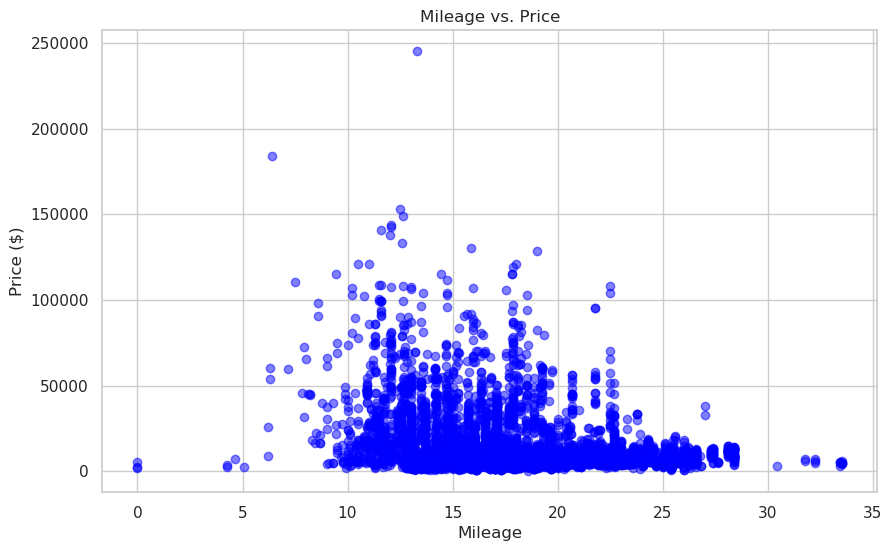

In [58]:
# 산점도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(df_new['Mileage'],df_new['Price'], color='blue', alpha=0.5)
plt.title('Mileage vs. Price')
plt.xlabel('Mileage')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

In [59]:
# 선형회귀분석
import statsmodels.api as sm

# 독립 변수에 상수항 추가
X = sm.add_constant(sampled_data['Mileage'])
# 종속 변수
Y = sampled_data['Price']

# OLS(Ordinary Least Squares) 모델을 사용한 선형 회귀 분석
model = sm.OLS(Y, X).fit()

# 결과 요약 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     581.8
Date:                Sun, 10 Mar 2024   Prob (F-statistic):          1.09e-121
Time:                        23:24:36   Log-Likelihood:                -55705.
No. Observations:                5000   AIC:                         1.114e+05
Df Residuals:                    4998   BIC:                         1.114e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.95e+04   1045.500     37.781      0.0

### 가설3. Seats 수에 따라 중고차 가격(Price) 사이에 연관성이 있다
* 귀무가설(H0): 자동차의 좌석 수(Seats)와 중고차 가격(Price) 사이에는 연관성이 없다.
* 대립가설(H1): 자동차의 좌석 수(Seats)와 중고차 가격(Price) 사이에는 연관성이 있다.

In [60]:
df_new['Seats'].value_counts()

5.0     5166
7.0      699
8.0      136
4.0      102
6.0       32
2.0       16
10.0       5
9.0        3
0.0        1
Name: Seats, dtype: int64

In [61]:
df_new.loc[df_new['Seats'] == 0, 'Seats'] = 5

In [62]:
df_new['Seats'].value_counts()

5.0     5167
7.0      699
8.0      136
4.0      102
6.0       32
2.0       16
10.0       5
9.0        3
Name: Seats, dtype: int64

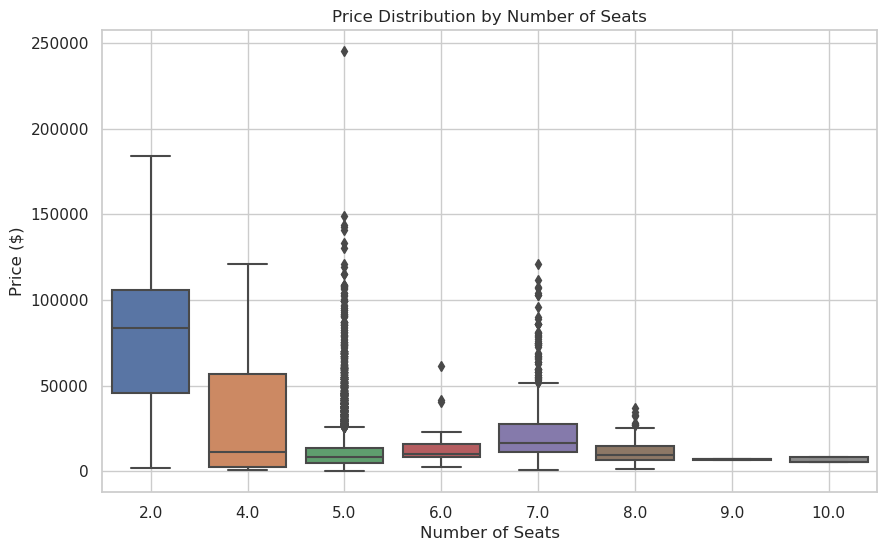

In [63]:
# 'Seats'별로 'Price'의 분포를 박스 플롯으로 표현
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=df_new['Seats'], y=df_new['Price'], data=df_new)
plt.title('Price Distribution by Number of Seats')
plt.xlabel('Number of Seats')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

In [64]:
# 정규성 검사
import scipy.stats as stats

# 다시 정규성 검사 시도
for seat in df_new['Seats'].unique():
    seat_data = df_new[df_new['Seats'] == seat]['Price']
    stat, p = stats.shapiro(seat_data)  # 결측치 제외
    if np.isnan(stat):
        print(f'Seat {seat}: 데이터 확인 필요')
    else:
        print(f'Seat {seat}: Statistics={stat}, p={p}')

Seat 5.0: Statistics=0.613311767578125, p=0.0
Seat 7.0: Statistics=0.773139238357544, p=5.586044323130153e-30
Seat 8.0: Statistics=0.8940694332122803, p=2.1751292322846894e-08
Seat 4.0: Statistics=0.8384846448898315, p=3.530348902103242e-09
Seat 6.0: Statistics=0.6961013674736023, p=7.605262908327859e-07
Seat 2.0: Statistics=0.9586019515991211, p=0.6365018486976624
Seat 10.0: Statistics=0.7589177489280701, p=0.035920970141887665
Seat 9.0: Statistics=0.9825587272644043, p=0.7470331192016602


In [65]:
# Levene의 검정을 사용하여 등분산성 검사

# sampled_data에서 각 연도별 'Price' 데이터를 선택하고, 그룹별 샘플이 충분한지 확인
seat_data = [df_new[df_new['Seats'] == seat]['Price'] for seat in df_new['Seats'].unique()]

# Levene의 검정을 사용하여 등분산성 검사 수행
stat, p = stats.levene(*seat_data)
print(f'Levene의 검정 결과: Statistics={stat}, p={p}')

Levene의 검정 결과: Statistics=39.28555173404139, p=2.3235320789701273e-54


In [66]:
# 'Seats' 칼럼으로 그룹화한 후 각 그룹의 'Price'에 대해 ANOVA 검정 수행
anova_result = stats.f_oneway(*[group['Price'].dropna() for name, group in df_new.groupby('Seats')])

print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

F-statistic: 84.12710345173726, p-value: 2.7291863399641804e-117


### 3-5. 데이터 정리

In [67]:
# 필요없는 변수 drop

# del df_new['Location']
del df_new['Brand']
del df_new['Model']

In [68]:
# 데이터 최종 확인
df_new

,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0
1,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0
2,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0
3,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0
4,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0
...,...,...,...,...,...,...,...,...,...,...,...
7228,Pune,10822.70,2016,41413,Diesel,Manual,First,27.28,1047.0,69.00,5.0
7231,Kochi,13474.72,2017,39015,Petrol,Manual,First,17.00,1497.0,121.36,5.0
7232,Mumbai,27838.55,2018,6000,Petrol,Manual,First,16.00,1368.0,160.00,5.0
7235,Kochi,16203.39,2017,21380,Diesel,Manual,First,24.30,1248.0,88.50,5.0


## 4. Modeling

In [69]:
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from statsmodels.api import qqplot,add_constant
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# 평가
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline

#### Encoding

In [70]:
# 범주형 변수 dummy화
df_raw_dummy = pd.get_dummies(df_new)
df_raw_dummy.head()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Location_Ahmedabad,Location_Bangalore,Location_Chennai,...,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,2682.68,2010,72000,26.60,998.0,58.16,5.0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
1,19162.00,2015,41000,19.67,1582.0,126.20,5.0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
2,6898.32,2011,46000,18.20,1199.0,88.70,5.0,0,0,1,...,0,0,0,1,0,1,1,0,0,0
3,9197.76,2012,87000,20.77,1248.0,88.76,7.0,0,0,1,...,0,1,0,0,0,1,1,0,0,0
4,27194.71,2013,40670,15.20,1968.0,140.80,5.0,0,0,0,...,0,1,0,0,1,0,0,0,1,0


In [71]:
df_raw_dummy.rename(columns={'Owner_Type_Fourth & Above': 'Owner_Type_Fourth_Above'}, inplace=True)

In [72]:
df_raw_dummy.corr().round(3)

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Location_Ahmedabad,Location_Bangalore,Location_Chennai,...,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth_Above,Owner_Type_Second,Owner_Type_Third
Price,1.000,0.304,-0.167,-0.324,0.640,0.756,0.054,-0.012,0.080,-0.054,...,-0.052,0.315,-0.025,-0.303,0.582,-0.582,0.095,-0.020,-0.077,-0.056
Year,0.304,1.000,-0.455,0.302,-0.056,0.025,0.010,-0.003,-0.044,-0.135,...,0.018,0.120,-0.033,-0.121,0.098,-0.098,0.372,-0.073,-0.298,-0.233
Kilometers_Driven,-0.167,-0.455,1.000,-0.143,0.156,-0.003,0.215,-0.011,0.007,0.151,...,-0.005,0.227,0.003,-0.227,-0.108,0.108,-0.204,0.076,0.164,0.114
Mileage,-0.324,0.302,-0.143,1.000,-0.636,-0.541,-0.341,0.034,-0.068,-0.004,...,0.164,0.109,0.010,-0.141,-0.359,0.359,0.148,-0.045,-0.121,-0.083
Engine,0.640,-0.056,0.156,-0.636,1.000,0.866,0.397,-0.009,0.084,-0.001,...,-0.085,0.426,-0.040,-0.407,0.499,-0.499,-0.051,0.020,0.044,0.019
Power,0.756,0.025,-0.003,-0.541,0.866,1.000,0.095,-0.008,0.090,-0.033,...,-0.086,0.284,-0.039,-0.265,0.639,-0.639,-0.023,-0.004,0.026,-0.003
Seats,0.054,0.010,0.215,-0.341,0.397,0.095,1.000,-0.002,0.017,0.010,...,-0.032,0.309,-0.014,-0.302,-0.071,0.071,-0.004,0.043,-0.004,0.012
Location_Ahmedabad,-0.012,-0.003,-0.011,0.034,-0.009,-0.008,-0.002,1.000,-0.049,-0.059,...,0.008,0.034,-0.008,-0.035,-0.007,0.007,0.007,-0.007,0.003,-0.027
Location_Bangalore,0.080,-0.044,0.007,-0.068,0.084,0.090,0.017,-0.049,1.000,-0.074,...,-0.024,0.042,-0.010,-0.036,0.066,-0.066,-0.113,0.010,0.106,0.029
Location_Chennai,-0.054,-0.135,0.151,-0.004,-0.001,-0.033,0.010,-0.059,-0.074,1.000,...,-0.016,0.030,-0.012,-0.026,-0.034,0.034,-0.115,0.022,0.076,0.116


In [73]:
## 평가
mse, rmse, mae, mape = [], [], [], []
## best parameter 목록
best_params = {}

### 4-1. Multi Linear Regression

In [74]:
# 회귀 모델 생성
df_train,df_test = train_test_split(df_raw_dummy,test_size = 0.3, random_state = 1234)
print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (4312, 28)
test data size : (1848, 28)


In [75]:
traincol = df_train.columns.tolist()
print(traincol)
for i in traincol:
    print(i,end=" ")
    print("+",end=" ")

['Price', 'Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Location_Ahmedabad', 'Location_Bangalore', 'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi', 'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi', 'Location_Kolkata', 'Location_Mumbai', 'Location_Pune', 'Fuel_Type_CNG', 'Fuel_Type_Diesel', 'Fuel_Type_LPG', 'Fuel_Type_Petrol', 'Transmission_Automatic', 'Transmission_Manual', 'Owner_Type_First', 'Owner_Type_Fourth_Above', 'Owner_Type_Second', 'Owner_Type_Third']
Price + Year + Kilometers_Driven + Mileage + Engine + Power + Seats + Location_Ahmedabad + Location_Bangalore + Location_Chennai + Location_Coimbatore + Location_Delhi + Location_Hyderabad + Location_Jaipur + Location_Kochi + Location_Kolkata + Location_Mumbai + Location_Pune + Fuel_Type_CNG + Fuel_Type_Diesel + Fuel_Type_LPG + Fuel_Type_Petrol + Transmission_Automatic + Transmission_Manual + Owner_Type_First + Owner_Type_Fourth_Above + Owner_Type_Second + Owner_Type_Third + 

In [76]:
import statsmodels.formula.api as smf

# OLS 모델 학습
reg_model = smf.ols(formula='Price ~ Year + Kilometers_Driven + Mileage + Engine + Power + Seats + Location_Ahmedabad + Location_Bangalore + Location_Chennai + Location_Coimbatore + Location_Delhi + Location_Hyderabad + Location_Jaipur + Location_Kochi + Location_Kolkata + Location_Mumbai + Location_Pune + Fuel_Type_CNG + Fuel_Type_Diesel + Fuel_Type_LPG + Fuel_Type_Petrol + Transmission_Automatic + Transmission_Manual + Owner_Type_First + Owner_Type_Second + Owner_Type_Third', data=df_train)
reg_result = reg_model.fit()

# 결과 요약 출력
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     404.1
Date:                Sun, 10 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:24:37   Log-Likelihood:                -45880.
No. Observations:                4312   AIC:                         9.181e+04
Df Residuals:                    4288   BIC:                         9.196e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.41

In [77]:
df_train_x = df_train.drop('Price',axis=1)
df_train_x_const = add_constant(df_train_x)

# 다중공산성 확인
df_vif = pd.DataFrame()
df_vif['variable'] = df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i) for i in range(df_train_x_const.shape[1])]

df_vif.sort_values('VIF',ascending=True).round(2)

,variable,VIF
0,const,0.00
2,Kilometers_Driven,1.53
1,Year,1.91
6,Seats,1.93
3,Mileage,3.20
5,Power,6.90
4,Engine,9.11
25,Owner_Type_Fourth_Above,inf
24,Owner_Type_First,inf
23,Transmission_Manual,inf


In [78]:
# VIF 높은 변수 제거
reg_model = smf.ols(formula = "Price ~ Year + Kilometers_Driven + Mileage + Engine + Power + Seats",data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     1367.
Date:                Sun, 10 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:24:38   Log-Likelihood:                -46066.
No. Observations:                4312   AIC:                         9.215e+04
Df Residuals:                    4305   BIC:                         9.219e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.913e+06   1.21e+0

In [79]:
df_train_x = df_train[["Year","Kilometers_Driven","Mileage","Engine","Power",'Seats']]
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i) for i in range(df_train_x_const.shape[1])]

df_vif.sort_values('VIF',inplace=True)
df_vif.round(2)

,variable,VIF
2,Kilometers_Driven,1.39
1,Year,1.52
6,Seats,1.82
3,Mileage,2.03
5,Power,6.06
4,Engine,7.47
0,const,564426.04


In [80]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수: ",r2_score(df_train['Price'],train_pred))
print("test data의 결정계수: ",r2_score(df_test['Price'],test_pred))

train data의 결정계수:  0.6558054900014251
test data의 결정계수:  0.6536971063369584


In [81]:
print("train data의 실제값: \n",df_test['Price'].head(10))
print("test data의 예측값: \n",test_pred[:10])

train data의 실제값: 
 1835     6055.19
5701    15114.99
3878    25232.52
1839     8201.34
4573     9197.76
3560     7358.21
6114    13490.05
5575    10700.06
5138     9044.46
5350    10347.48
Name: Price, dtype: float64
test data의 예측값: 
 1835     7519.013427
5701    20226.332526
3878    28500.747593
1839     7200.263741
4573    10943.636540
3560    10061.933678
6114    13121.243508
5575    11741.243442
5138    10144.829657
5350    18455.160180
dtype: float64


#### 후진제거법을 이용한 변수 선택

In [82]:
df_train_y = df_train['Price']
df_train_x = df_train.drop('Price',axis=1)

model = LinearRegression()

rfe = RFE(estimator = model,n_features_to_select = 5).fit(df_train_x,df_train_y)

selected_cols = df_train_x.columns[rfe.support_]

removed_cols = df_train_x.columns[~rfe.support_]

print("Selected Variables: {}".format(selected_cols))

print("Removed Variables: {}".format(removed_cols))

Selected Variables: Index(['Location_Coimbatore', 'Fuel_Type_LPG', 'Fuel_Type_Petrol',
       'Transmission_Automatic', 'Transmission_Manual'],
      dtype='object')
Removed Variables: Index(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'Location_Ahmedabad', 'Location_Bangalore', 'Location_Chennai',
       'Location_Delhi', 'Location_Hyderabad', 'Location_Jaipur',
       'Location_Kochi', 'Location_Kolkata', 'Location_Mumbai',
       'Location_Pune', 'Fuel_Type_CNG', 'Fuel_Type_Diesel',
       'Owner_Type_First', 'Owner_Type_Fourth_Above', 'Owner_Type_Second',
       'Owner_Type_Third'],
      dtype='object')


In [83]:
reg_model = smf.ols(formula = "Price ~ Year + Kilometers_Driven + Engine +Power + Seats",data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     1641.
Date:                Sun, 10 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:24:38   Log-Likelihood:                -46067.
No. Observations:                4312   AIC:                         9.215e+04
Df Residuals:                    4306   BIC:                         9.218e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.919e+06   1.12e+0

<Axes: >

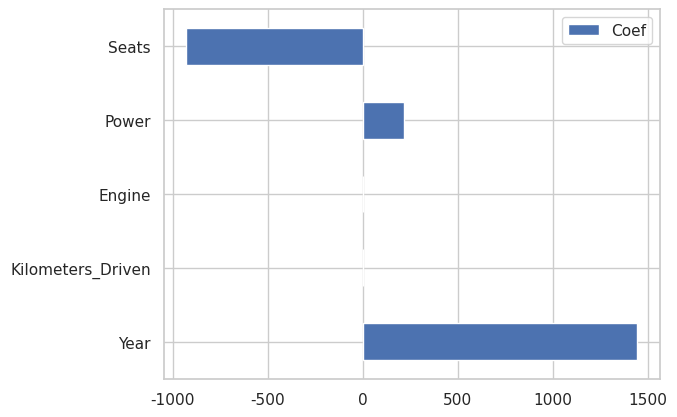

In [84]:
# 설명변수 중요도
df_reg_coef = pd.DataFrame({"Coef":reg_result.params.values[1:]},
                          index = ['Year','Kilometers_Driven','Engine','Power','Seats'])
df_reg_coef.plot.barh(y='Coef')

#### 모델링 결과 저장

In [85]:
df_train, df_test = train_test_split(df_raw_dummy,test_size = 0.3, random_state = 1234)

df_raw_y = df_raw_dummy['Price']
df_raw_x = df_raw_dummy.drop('Price',axis=1,inplace=False)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,test_size=0.3,random_state=1234)

In [86]:
## 평가
mse, rmse, mae, mape = [], [], [], []

In [87]:
# 회귀분석
lr_model = smf.ols(formula = "Price ~ Year + Kilometers_Driven + Engine +Power + Seats",data = df_train)
lr_result = lr_model.fit()
lr_y_pred = lr_result.predict(df_test)

mse.append(mean_squared_error(df_test['Price'],lr_y_pred))
rmse.append(mean_squared_error(df_test['Price'],lr_y_pred,squared=False))
mae.append(mean_absolute_error(df_test['Price'],lr_y_pred))
mape.append(mean_absolute_percentage_error(df_test['Price'],lr_y_pred))

In [88]:
# 릿지
ridge = Ridge(random_state=1234, alpha = 1)  
ridge.fit(df_train_x, df_train_y)

test_pred_ridge = ridge.predict(df_test_x)
mse.append(mean_squared_error(df_test_y, test_pred_ridge))
rmse.append(mean_squared_error(df_test_y, test_pred_ridge, squared=False))
mae.append(mean_absolute_error(df_test_y, test_pred_ridge))
mape.append(mean_absolute_percentage_error(df_test_y, test_pred_ridge))

In [89]:
# 라쏘
lasso = Lasso(random_state=1234, alpha = 1)
lasso.fit(df_train_x, df_train_y)

test_pred_lasso = lasso.predict(df_test_x)
mse.append(mean_squared_error(df_test_y, test_pred_lasso))
rmse.append(mean_squared_error(df_test_y, test_pred_lasso, squared=False))
mae.append(mean_absolute_error(df_test_y, test_pred_lasso))
mape.append(mean_absolute_percentage_error(df_test_y, test_pred_lasso))

In [90]:
# 엘라스틱
elastic = ElasticNet(random_state=1234, alpha = 1, l1_ratio = 0.5)
elastic.fit(df_train_x, df_train_y)

test_pred_elastic = elastic.predict(df_test_x)
mse.append(mean_squared_error(df_test_y, test_pred_elastic))
rmse.append(mean_squared_error(df_test_y, test_pred_elastic, squared=False))
mae.append(mean_absolute_error(df_test_y, test_pred_elastic))
mape.append(mean_absolute_percentage_error(df_test_y, test_pred_elastic))

### 4-1. DecisionTree, RandomForest, GradientBoosting

In [91]:
from sklearn.model_selection import GridSearchCV

# 모델
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [92]:
!pip install tqdm

In [93]:
import time
from tqdm import tqdm

#### Data

In [104]:
df = df_new

## 인코딩
for col in ['Fuel_Type', 'Transmission', 'Owner_Type', 'Location']:
    df_encoded = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, df_encoded], axis=1)
    df.drop(col, axis=1, inplace=True)

## 데이터 분할
df_x, df_y = df.drop('Price', axis = 1), df['Price']
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, test_size = 0.3, random_state = 1234)

#### List of Model

In [107]:
## 사용할 모델
# lr = smf.ols('Price ~')
dt = DecisionTreeRegressor(random_state = 1234)
rf = RandomForestRegressor(random_state = 1234)
gb = GradientBoostingRegressor(random_state = 1234)

## 변수 중요도 
df_importance = pd.DataFrame()
df_importance["Feature"] = train_x.columns

#### Parameter Candidates

In [108]:
## parameter candidates
dt_params = {
    "min_samples_leaf": [5, 6, 7, 8, 9, 10],
    "min_samples_split": [40, 45, 50, 55, 60],
    "max_depth": [3, 5, 7, 9],
}
rf_params = {
    "max_features" : ["sqrt", "log2"],
    "n_estimators" : [200,300],
    "max_depth": [5, 6, 7, 8, 9, 10],
    "min_samples_split": [5, 10, 15, 20, 25], 
    "min_samples_leaf": [10, 15, 20, 25, 30]
}
gb_params = {
    "max_features" : ["sqrt", "log2"],
    "n_estimators": [200, 300],
    "min_samples_leaf": [5, 10, 15, 20, 25],
    "min_samples_split": [40, 45, 50, 55, 60, 65],
    "max_depth": [5, 6, 7, 8, 9, 10]
}

## parameter dictionary
param_dict = {
    0: dt_params,
    1: rf_params,
    2: gb_params
}

#### Models

In [ ]:
start_time = time.time()

models = [dt, rf, gb]
model_names = ["LinearRegression", "Ridge", "Lasso", "Elastic","DecisionTree", "RandomForest", "GradientBoosting"]

fig1 = plt.figure(figsize = (10, 13)) 

# best parameter 목록
best_params = {}

n = 0

for model in tqdm(models):              ## Model Selection - 나중에 random_state 다 빼기
    # GridSearchCVs
        # cv: crossvalidation 수 (default = 5)
        # refit: 최적의 parameter를 찾은 뒤 최종 적용
        # return_train_score: train score의 평균 return

    grid = GridSearchCV(
        model, param_dict[n], scoring="r2", n_jobs = -1, return_train_score = True, refit = True
    )
    # 적용
    grid.fit(train_x, train_y)
    
    # GridSearchCV가 고른 parameter로 예측
    _pred = grid.best_estimator_.predict(test_x)
    
    # 평가 저장
    mse.append(mean_squared_error(test_y, _pred))
    rmse.append(mean_squared_error(test_y, _pred, squared = False))
    mae.append(mean_absolute_error(test_y, _pred))
    mape.append(mean_absolute_percentage_error(test_y, _pred))

    ## best parameter 저장
    best_params[model_names[n + 4]] = grid.best_params_
    
    
    ## 설명변수 중요도
    col_name = model_names[n + 4] + " Importance"
    df_importance[col_name] = grid.best_estimator_.feature_importances_

    # df_feature_importance의 테이블을 중요도 순으로 정렬
    df_importance.sort_values(col_name, ascending=False, inplace = True)
    df_importance.round(3)
    
    # 시각화
    df_importance.sort_values(col_name, ascending = True, inplace = True)
    coordinates = range(len(df_importance))
    
    ax = fig1.add_subplot(3, 1, n + 1)
    ax.barh(y = coordinates, width = df_importance[col_name], label=col_name)
    plt.yticks(coordinates, df_importance["Feature"])
    ax.set_title(col_name)      
    
    n += 1
    
    
end_time = time.time()

 67%|█████████████████████████████▎              | 2/3 [08:24<04:56, 296.45s/it]

In [ ]:
execution_time = end_time - start_time

print("코드 실행 시간: {:.2f} 초".format(execution_time))

#### Best Parameters of each Model

In [ ]:
best_params

## 5. 성능 비교

In [ ]:
fig2, ax2 = plt.subplots(2, 2, figsize = (28, 20)) 

ax2[0, 0].bar(model_names, mse)
ax2[0, 0].set_title("MSE").set_fontsize(19)

ax2[0, 1].bar(model_names, rmse)
ax2[0, 1].set_title("RMSE").set_fontsize(19)


ax2[1, 0].bar(model_names, mae)
ax2[1, 0].set_title("MAE").set_fontsize(19)

ax2[1, 1].bar(model_names, mape)
ax2[1, 1].set_title("MAPE").set_fontsize(19)    